In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

# sklearn imputers
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.neighbors import KDTree

# sklearn models
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


In [2]:
path = '../data/modified/trees_first.pkl'
trees= pd.read_pickle(path)

In [3]:
trees = trees.astype({'ADR_SECTEUR':'object'})

trees_train,trees_test = train_test_split(trees,random_state=2708)

# Transform data

## Preprocessing

In [11]:
# Transforme GEOJSON data in two features
class TransformGEOJSON(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df,y=None):
        return self
    def transform(self, df):
        df_new = df.copy()
        pat = '([0-9]+.[0-9]+)'
        df_new[['latitude','longitude']] = df_new.GeoJSON.str.extractall(pat).unstack(level=1).astype('float64')
        df_new = df_new.drop('GeoJSON',axis=1)
        return df_new

# Drop features without info (1) or identifiers features
class DropuniqueCol(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        to_drop = ['ELEM_POINT_ID','CODE','NOM','GENRE','GENRE_DESC','CATEGORIE','CATEGORIE_DESC','BIEN_REFERENCE','SOUS_CATEGORIE','CODE_PARENT']
        df_new = df.drop(to_drop,axis=1)
        return df_new

# Drop Na features     
class DropNaWithSaveCol(BaseEstimator,TransformerMixin):
    def __init__(self,na_threshold=0.5):
        self.threshold = na_threshold
    def fit(self, df):
        na = df.isna().sum().div(len(df)).sort_values(ascending=False)
        self.col_na = na.where(na>=self.threshold).dropna().index
        return self
    def transform(self, df):
        check_is_fitted(self, ['col_na'])
        df_new= df.drop(self.col_na,axis=1)
        return df_new


    


## Creating simple custom imputer

In [96]:
class InputMissingValues(BaseEstimator,TransformerMixin):
    
    def __init__(self,to_use=True):
        self.to_use=to_use
        self.errors = []
        
    def fit(self, df,y=None):
        self.most_freq_genre = df.GENRE_BOTA.mode().values[0]
        self.gerne_espece = df.groupby('GENRE_BOTA').ESPECE.value_counts(dropna=False).sort_values(ascending=False)
        self.fill_with = 'ND'
        self.errors = []
        return self
    
    def transform(self, df,y=None):
        if self.to_use:
            df_new = df.copy()
            df_new['COLLECTIVITE'] = df_new['COLLECTIVITE'].fillna(self.fill_with)
            df_new['STADEDEDEVELOPPEMENT'] = df_new['COLLECTIVITE'].fillna(self.fill_with)
            df_new['GENRE_BOTA'] = df_new['GENRE_BOTA'].fillna(self.most_freq_genre)
            
            liste_ind = []
            liste_replace = []
            
            for ind,row in df_new.iterrows():
                if isinstance(row['ESPECE'], float):
                    liste_ind.append(ind)
                    genre = row['GENRE_BOTA']
                    if genre == 'Poncinos':
                        self.errors.append((ind,row))
                    # check database for most common species accociated with gern
                    species_replace = self.gerne_espece.xs(genre,level=0).idxmax()
                    if isinstance(species_replace, float):
                        species_replace = self.fill_with
                    liste_replace.append(species_replace)
            if len(liste_ind) != 0:
                for ind,replace in zip(liste_ind,liste_replace):
                    df_new.loc[ind,'ESPECE'] = replace
            return  df_new
        else:
            return df

## Preprocess pipeline

In [97]:
preprocess_pipeline = Pipeline([("geo", TransformGEOJSON()),
                                ('dropuni',DropuniqueCol()),
                                ('na',DropNaWithSaveCol())])

## Feature add

In [98]:
# Create Bio features

class Bio(BaseEstimator,TransformerMixin):
    def __init__(self,to_use=True):
        self.to_use = to_use
    def fit(self, df,y=None):
        return self
    def transform(self,df,y=None):
        if self.to_use:
            df_new = df.copy()
            df_new['ESPECE'] = df_new['ESPECE'].map(str).replace('nan',' ')
            df_new['GENRE_BOTA'] = df_new['GENRE_BOTA'].map(str).replace('nan',' ')
            df_new['BIO'] = df_new['GENRE_BOTA'] + " " + df['ESPECE']
            df_new = df_new.drop(['GENRE_BOTA','ESPECE'],axis=1)
            return df_new
        else:
            return df

feature_adder = Pipeline(['Bio',Bio()])

## Columns Transformer 

In [125]:
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')
numerical_transformer = StandardScaler()

transformer = ColumnTransformer(
[("num_trans", numerical_transformer, make_column_selector(dtype_exclude="object")),
("cat_trans", categorical_transformer, make_column_selector(dtype_include='object'))])

## Transform Train

In [99]:
predictor_train = trees_train.drop('ANNEEDEPLANTATION',axis=1)

In [100]:
annee_train = trees_train.ANNEEDEPLANTATION

In [101]:
processed_train_predictors = preprocess_pipeline.fit_transform(predictor_train)
processed_train_predictors

,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,COLLECTIVITE,latitude,longitude
9601,Arbre d'espaces ouverts,Pc Savane local pétanque,3,Acer,platanoides,Arbre adulte,Ville de Grenoble,5.706195,45.175643
1784,Arbre de voirie,Pl André Malraux bord du park,2,Tilia,cordata,Arbre adulte,Grenoble Alpes Métropole,5.729218,45.185658
12932,Arbre d'enceintes fermées,Cimetière du Grand Sablon,2,Libocedrus,decurrens,Arbre adulte,Ville de Grenoble,5.744626,45.192890
17720,Arbre d'espaces ouverts,Pc Ch Elysés Ouest,3,Celtis,australis,Arbre adulte,Ville de Grenoble,5.705889,45.163258
19655,Arbre d'espaces ouverts,Prc Mis Est Palais des sports,5,Paulownia,fortunei,Arbre adulte,Ville de Grenoble,5.741748,45.186138
...,...,...,...,...,...,...,...,...,...
1751,Arbre d'espaces ouverts,Prc Mis dans vivaces Mairie,5,Cercis,siliquastrum,Arbre adulte,Ville de Grenoble,5.736233,45.185974
9389,Arbre d'espaces ouverts,R Arlequin pourtour silo 03,6,Betula,alba,Arbre adulte,Ville de Grenoble,5.731841,45.163756
17367,Arbre de voirie,R Capitaine Camine park,3,Platanus,acerifolia,Arbre jeune,Grenoble Alpes Métropole,5.713157,45.173429
18855,Arbre d'espaces ouverts,Ch Gordes Est conservatoire,4,Malus,domestica,Arbre adulte,Ville de Grenoble,5.737468,45.176643


## Creating custom imputer based on KDtree

In [78]:
processed_train_predictors

,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,COLLECTIVITE,latitude,longitude
9601,Arbre d'espaces ouverts,Pc Savane local pétanque,3,Acer,platanoides,Arbre adulte,Ville de Grenoble,5.706195,45.175643
1784,Arbre de voirie,Pl André Malraux bord du park,2,Tilia,cordata,Arbre adulte,Grenoble Alpes Métropole,5.729218,45.185658
12932,Arbre d'enceintes fermées,Cimetière du Grand Sablon,2,Libocedrus,decurrens,Arbre adulte,Ville de Grenoble,5.744626,45.192890
17720,Arbre d'espaces ouverts,Pc Ch Elysés Ouest,3,Celtis,australis,Arbre adulte,Ville de Grenoble,5.705889,45.163258
19655,Arbre d'espaces ouverts,Prc Mis Est Palais des sports,5,Paulownia,fortunei,Arbre adulte,Ville de Grenoble,5.741748,45.186138
...,...,...,...,...,...,...,...,...,...
1751,Arbre d'espaces ouverts,Prc Mis dans vivaces Mairie,5,Cercis,siliquastrum,Arbre adulte,Ville de Grenoble,5.736233,45.185974
9389,Arbre d'espaces ouverts,R Arlequin pourtour silo 03,6,Betula,alba,Arbre adulte,Ville de Grenoble,5.731841,45.163756
17367,Arbre de voirie,R Capitaine Camine park,3,Platanus,acerifolia,Arbre jeune,Grenoble Alpes Métropole,5.713157,45.173429
18855,Arbre d'espaces ouverts,Ch Gordes Est conservatoire,4,Malus,domestica,Arbre adulte,Ville de Grenoble,5.737468,45.176643


In [79]:
test_pos = processed_train_predictors[['latitude','longitude']]

In [80]:
na = processed_train_predictors.isna().sum(axis=1).values
na[na>1] = 1

In [81]:
test_pos['na'] = na

/tmp/ipykernel_43516/983512539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pos['na'] = na


In [82]:
tree = KDTree(test_pos)

In [83]:
test_pos[test_pos.na == 1]

,latitude,longitude,na
23300,5.741641,45.198570,1
26062,5.705979,45.162356,1
23680,5.734933,45.176984,1
29119,5.735284,45.163227,1
31231,5.731959,45.177532,1
...,...,...,...
26738,5.706475,45.203417,1
8838,5.736906,45.163398,1
23664,5.736701,45.161216,1
28946,5.735231,45.164474,1


In [84]:
processed_train_predictors

,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,COLLECTIVITE,latitude,longitude
9601,Arbre d'espaces ouverts,Pc Savane local pétanque,3,Acer,platanoides,Arbre adulte,Ville de Grenoble,5.706195,45.175643
1784,Arbre de voirie,Pl André Malraux bord du park,2,Tilia,cordata,Arbre adulte,Grenoble Alpes Métropole,5.729218,45.185658
12932,Arbre d'enceintes fermées,Cimetière du Grand Sablon,2,Libocedrus,decurrens,Arbre adulte,Ville de Grenoble,5.744626,45.192890
17720,Arbre d'espaces ouverts,Pc Ch Elysés Ouest,3,Celtis,australis,Arbre adulte,Ville de Grenoble,5.705889,45.163258
19655,Arbre d'espaces ouverts,Prc Mis Est Palais des sports,5,Paulownia,fortunei,Arbre adulte,Ville de Grenoble,5.741748,45.186138
...,...,...,...,...,...,...,...,...,...
1751,Arbre d'espaces ouverts,Prc Mis dans vivaces Mairie,5,Cercis,siliquastrum,Arbre adulte,Ville de Grenoble,5.736233,45.185974
9389,Arbre d'espaces ouverts,R Arlequin pourtour silo 03,6,Betula,alba,Arbre adulte,Ville de Grenoble,5.731841,45.163756
17367,Arbre de voirie,R Capitaine Camine park,3,Platanus,acerifolia,Arbre jeune,Grenoble Alpes Métropole,5.713157,45.173429
18855,Arbre d'espaces ouverts,Ch Gordes Est conservatoire,4,Malus,domestica,Arbre adulte,Ville de Grenoble,5.737468,45.176643


In [85]:
list_sddev = processed_train_predictors.STADEDEDEVELOPPEMENT.value_counts().index.to_list()

In [86]:
processed_train_predictors.isna().sum()

SOUS_CATEGORIE_DESC        0
CODE_PARENT_DESC           0
ADR_SECTEUR                0
GENRE_BOTA                17
ESPECE                  1143
STADEDEDEVELOPPEMENT    1610
COLLECTIVITE               0
latitude                   0
longitude                  0
dtype: int64

In [87]:
for row in processed_train_predictors.itertuples():
    if row.STADEDEDEVELOPPEMENT not in list_sddev :
        i = row.Index
        test_query = test_pos[test_pos.index==i].values.reshape(1,-1)        
        query_dist,query_ind = tree.query(test_query,k=30,return_distance=True)
        list_query=[]
        for ind in query_ind:
            list_query.append(processed_train_predictors.iloc[ind])
        df_query = pd.concat(list_query)
        df_query['distance']=query_dist.reshape(-1,1)
            

In [88]:
processed_train_predictors.isna().sum(axis=1).sort_values(ascending=False)

23015    3
23503    3
22865    3
22860    3
23501    3
        ..
16640    0
25463    0
7694     0
23981    0
2455     0
Length: 22693, dtype: int64

In [278]:
test_query

,latitude,longitude,na
23300,5.741641,45.19857,1


In [295]:
test_query = test_pos[test_pos.index==23015].values.reshape(1,-1)        

In [296]:
test_query

array([[ 5.71987004, 45.17990662,  1.        ]])

In [297]:
test_pos[test_pos.index==23015]  
processed_train_predictors[processed_train_predictors.index==23015]

,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,COLLECTIVITE,latitude,longitude
23015,Arbre d'espaces ouverts,R Cdt de Reynies,4,NaN,NaN,NaN,Grenoble Alpes Métropole,5.71987,45.179907


In [301]:
query_dist,query_ind = tree.query(test_query,k=30,return_distance=True)

In [302]:
query_ind

array([[22676, 22663, 17206, 21915, 17230,  9178,  9222, 13912, 11818,
        11360,   710, 20008, 11093,  5919,   556,  7599,  8858,  5426,
        11507, 11965, 22601, 15923,  7696,  2202,  4756, 14797,  8890,
        11620,  9633,  6008]])

In [303]:
list_query=[]
list_dist=[]
for dist,i in zip(query_dist,query_ind):
    list_query.append(processed_train_predictors.iloc[i])
df_query = pd.concat(list_query)

In [304]:
df_query['distance']=query_dist.reshape(-1,1)

In [319]:
df_query.dropna(subset='STADEDEDEVELOPPEMENT')

,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,COLLECTIVITE,latitude,longitude,distance
13639,Arbre d'espaces ouverts,Aire de jeux butte 04,6,Quercus,NaN,Arbre vieillissant,Ville de Grenoble,5.735711,45.164299,0.000453
8488,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736137,45.164063,0.000936
6245,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736125,45.163998,0.000953
29586,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736176,45.164036,0.000982
18708,Arbre d'espaces ouverts,R du Trident 12 et 13,6,Prunus,NaN,Arbre jeune,Ville de Grenoble,5.735352,45.165433,0.000998
29862,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736173,45.163963,0.001012
13971,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736230,45.164075,0.001017
14821,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736227,45.164002,0.001043
863,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736280,45.164042,0.001076
24168,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736330,45.164081,0.001110


In [322]:
mean = df_query.dropna(subset='STADEDEDEVELOPPEMENT').groupby('STADEDEDEVELOPPEMENT').distance.mean()

In [326]:
nb = df_query.dropna(subset='STADEDEDEVELOPPEMENT').STADEDEDEVELOPPEMENT.value_counts()

In [327]:
df_query.dropna(subset='STADEDEDEVELOPPEMENT').STADEDEDEVELOPPEMENT.value_counts().mul(mean).div(nb)

Arbre adulte          0.001029
Arbre jeune           0.000998
Arbre vieillissant    0.000453
dtype: float64

In [76]:
processed_train_predictors.isna().sum()

SOUS_CATEGORIE_DESC        0
CODE_PARENT_DESC           0
ADR_SECTEUR                0
GENRE_BOTA                17
ESPECE                  1143
STADEDEDEVELOPPEMENT    1610
COLLECTIVITE               0
latitude                   0
longitude                  0
dtype: int64

## Test pipeline Transformer with y

In [127]:
pipeline_test = Pipeline(steps=[('custom_simple_imputer',InputMissingValues(True)),
                       ('f_adder_1',Bio()),
                       ('transformer',transformer)])

In [128]:
pipeline_test.fit_transform(predictor_train)

/home/raphael.bouvet@Digital-Grenoble.local/anaconda3/envs/ml_1/lib/python3.9/site-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/raphael.bouvet@Digital-Grenoble.local/anaconda3/envs/ml_1/lib/python3.9/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/home/raphael.bouvet@Digital-Grenoble.local/anaconda3/envs/ml_1/lib/python3.9/site-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count


KeyboardInterrupt: 

# Modelisation

In [102]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[10],
           'model':[model_1]} 
model_2 = DecisionTreeRegressor()
param_2 = {'f_adder_1__to_use':[True],
           'model__min_samples_leaf':[1],
           'model':[model_2]} 
model_3 = SVR()
param_3 = {'f_adder_1__to_use':[True],
           'model__C':[10],
           'model':[model_3]} 
model_4 = LinearRegression()
param_4 = {'f_adder_1__to_use':[True],
           'model':[model_4]} 
model_5 = Lasso()
param_5 = {'f_adder_1__to_use':[True],
           'model__alpha':[10],
           'model':[model_5]} 

In [105]:
pipe = Pipeline(steps=[('custom_simple_imputer',InputMissingValues(True)),
                       ('f_adder_1',Bio()),
                       ('transformer',transformer),
                       ("model",model_1)])
params_list = [param_1,param_2,param_3,param_4,param_5]

grid_search = GridSearchCV(pipe,params_list,cv=5,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [106]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results.sort_values(by='rank_test_score')

/home/raphael.bouvet@Digital-Grenoble.local/anaconda3/envs/ml_1/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/raphael.bouvet@Digital-Grenoble.local/anaconda3/envs/ml_1/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Poncinos'

The above exception was the direct cause of the following exception:

Traceback (most recent c

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__n_estimators,param_model__min_samples_leaf,param_model__C,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.306327,0.152333,0.410670,0.142502,True,RandomForestRegressor(n_estimators=10),10,NaN,NaN,NaN,"{'f_adder_1__to_use': True, 'model': RandomFor...",-57.458213,-51.001269,-57.893635,-62.278909,NaN,NaN,NaN,1
1,2.453787,0.026497,0.348542,0.102207,True,DecisionTreeRegressor(),NaN,1,NaN,NaN,"{'f_adder_1__to_use': True, 'model': DecisionT...",-69.079533,-82.272086,-84.814717,-72.642353,NaN,NaN,NaN,2
2,23.248375,1.250922,1.683621,0.801509,True,SVR(),NaN,NaN,10,NaN,"{'f_adder_1__to_use': True, 'model': SVR(), 'm...",-72.449802,-74.643102,-76.237689,-73.450710,NaN,NaN,NaN,3
3,2.406461,0.091474,0.355017,0.104696,True,LinearRegression(),NaN,NaN,NaN,NaN,"{'f_adder_1__to_use': True, 'model': LinearReg...",-76.575224,-78.381858,-70.695247,-77.425549,NaN,NaN,NaN,4
4,1.631958,0.109949,0.339806,0.109569,True,Lasso(),NaN,NaN,NaN,10,"{'f_adder_1__to_use': True, 'model': Lasso(), ...",-312.989950,-319.720947,-317.132212,-321.213498,NaN,NaN,NaN,5


In [107]:
best_model = grid_search.best_params_

In [108]:
best_pipe = grid_search.best_estimator_

In [109]:
best_pipe.score(processed_train_predictors,annee_train)

0.9725354959059862

In [110]:
# check errors in model
pipe.named_steps['custom_simple_imputer'].errors

[]

# Test of best model on test dataset

In [111]:
test_predictors = trees_test.drop('ANNEEDEPLANTATION',axis=1)
annee_test = trees_test.ANNEEDEPLANTATION

In [112]:
process_test_predictors = preprocess_pipeline.transform(test_predictors)

In [113]:
annee_predicted = best_pipe.predict(process_test_predictors)
mean_squared_error(annee_test,annee_predicted)

50.051594183740924

In [114]:
best_pipe.score(process_test_predictors,annee_test)

0.8449936960659816

# Prediction on na values

In [115]:
path_first_na = '../data/modified/trees_first_na.pkl'
trees_na= pd.read_pickle(path_first_na)

In [116]:
trees_na

,ELEM_POINT_ID,CODE,NOM,GENRE,GENRE_DESC,CATEGORIE,CATEGORIE_DESC,SOUS_CATEGORIE,SOUS_CATEGORIE_DESC,CODE_PARENT,...,COURRIER,IDENTIFIANTPLU,TYPEIMPLANTATIONPLU,INTITULEPROTECTIONPLU,ANNEEABATTAGE,ESSOUCHEMENT,DIAMETREARBRE,CAUSEABATTAGE,COLLECTIVITE,GeoJSON
1075,39588,ESP38596,ESP38596,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP1185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7033870348283..."
1076,39589,ESP38597,ESP38597,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP1185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7034657665144..."
1077,39590,ESP38598,ESP38598,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7199743332099..."
1088,43402,ESP39987,ESP39987,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7139485923092..."
1089,43403,ESP39988,ESP39988,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7138453760140..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31603,46019,ESP41553,ESP41553,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[5.7358259784285..."
31604,46020,ESP41554,ESP41554,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[5.7356836831762..."
31605,46021,ESP41555,ESP41555,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[5.7362096829728..."
31606,46022,ESP41556,ESP41556,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP1034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[5.7355397923023..."


In [117]:
trees_na = trees_na.astype({'ADR_SECTEUR':'object'})

In [118]:
trees_na = trees_na.drop(['ANNEEDEPLANTATION'],axis=1)

In [119]:
processed_na = preprocess_pipeline.transform(trees_na)

In [120]:
y = best_pipe.predict(processed_na)

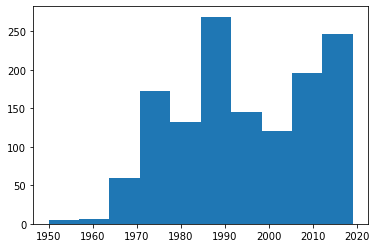

In [121]:
plt.hist(y);

# Hyperparameter tuning for random forest regressor

## Hyperparameter tuning

In [646]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[10,50,100],
           'model__min_samples_leaf':[1,10,20],
           'model':[model_1]} 

In [647]:
pipe = Pipeline(steps=[('custom_simple_imputer',InputMissingValues(True)),
                       ('f_adder_1',Bio()),
                       ('transformer',transformer),
                       ("model",model_1)])

In [648]:
params_list = [param_1]

grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [649]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results.sort_values(by='rank_test_score')

/home/raphael.bouvet@Digital-Grenoble.local/anaconda3/envs/ml_1/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/raphael.bouvet@Digital-Grenoble.local/anaconda3/envs/ml_1/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Poncinos'

The above exception was the direct cause of the following exception:

Traceback (most recent c

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__min_samples_leaf,param_model__n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,9.224277,0.129283,0.233401,0.031634,True,RandomForestRegressor(n_estimators=10),1,10,"{'f_adder_1__to_use': True, 'model': RandomFor...",-50.095220,...,-50.686576,-55.503759,-53.338933,-56.601296,-57.289013,NaN,-57.443482,NaN,NaN,1
1,40.354758,1.113144,0.274351,0.061428,True,RandomForestRegressor(n_estimators=10),1,50,"{'f_adder_1__to_use': True, 'model': RandomFor...",-46.663308,...,-46.132219,-52.154358,-50.758474,-52.392151,-56.390691,NaN,-52.047037,NaN,NaN,2
2,73.807838,1.814808,0.248422,0.037557,True,RandomForestRegressor(n_estimators=10),1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",-45.725467,...,-46.250288,-51.300068,-50.433136,-51.372906,-55.693374,NaN,-52.954784,NaN,NaN,3
3,5.504395,0.113166,0.201311,0.023234,True,RandomForestRegressor(n_estimators=10),10,10,"{'f_adder_1__to_use': True, 'model': RandomFor...",-83.245321,...,-86.904085,-87.347314,-90.596730,-87.839709,-88.801224,NaN,-88.930561,NaN,NaN,4
4,20.573359,0.231199,0.217330,0.025755,True,RandomForestRegressor(n_estimators=10),10,50,"{'f_adder_1__to_use': True, 'model': RandomFor...",-80.058679,...,-86.518511,-86.640584,-87.477020,-84.626270,-86.787133,NaN,-87.795605,NaN,NaN,5
5,39.301778,0.286465,0.238669,0.036679,True,RandomForestRegressor(n_estimators=10),10,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",-79.363490,...,-86.267697,-86.894868,-88.054465,-83.914669,-86.686460,NaN,-87.036574,NaN,NaN,6
6,4.561791,0.119907,0.203941,0.024163,True,RandomForestRegressor(n_estimators=10),20,10,"{'f_adder_1__to_use': True, 'model': RandomFor...",-107.272985,...,-117.440187,-111.570636,-111.851735,-107.506400,-112.960734,NaN,-113.785458,NaN,NaN,7
7,15.682154,0.172731,0.210928,0.026347,True,RandomForestRegressor(n_estimators=10),20,50,"{'f_adder_1__to_use': True, 'model': RandomFor...",-104.409909,...,-114.080395,-108.599912,-110.074763,-103.876360,-111.501882,NaN,-112.557282,NaN,NaN,8
8,27.950619,2.093679,0.177915,0.056489,True,RandomForestRegressor(n_estimators=10),20,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",-104.510166,...,-114.517950,-108.423460,-110.215358,-104.000588,-111.229589,NaN,-112.092129,NaN,NaN,9


In [650]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[25,50],
           'model__min_samples_leaf':[1,10,25],
           'model__max_features':['sqrt','log2'],
           'model__ccp_alpha':[0,0.001,0.01,0.1],
           'model':[model_1]} 
params_list = [param_1]

grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [651]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)

/home/raphael.bouvet@Digital-Grenoble.local/anaconda3/envs/ml_1/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/raphael.bouvet@Digital-Grenoble.local/anaconda3/envs/ml_1/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Poncinos'

The above exception was the direct cause of the following exception:

Traceback (most recent c

In [652]:
grid_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__ccp_alpha,param_model__max_features,param_model__min_samples_leaf,param_model__n_estimators,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,5.632690,0.082799,0.230462,0.033343,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,1,25,...,-44.670799,-48.058485,-46.340406,-45.401980,-53.069268,NaN,-47.972635,NaN,NaN,1
1,9.392215,0.099575,0.239878,0.034161,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,1,50,...,-44.077303,-45.553959,-43.042610,-42.726043,-53.653281,NaN,-45.738790,NaN,NaN,26
2,2.129218,0.079975,0.209198,0.018633,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,10,25,...,-185.565006,-193.840214,-178.437271,-176.861249,-190.954319,NaN,-186.156182,NaN,NaN,27
3,2.466100,0.073495,0.237469,0.047907,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,10,50,...,-185.196973,-191.632240,-179.617596,-176.884148,-186.246862,NaN,-183.253267,NaN,NaN,28
4,2.022063,0.035827,0.222708,0.043642,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,25,25,...,-248.803395,-263.202173,-237.331269,-252.214468,-258.933102,NaN,-256.531223,NaN,NaN,29


In [653]:
grid_results.sort_values(by='rank_test_score')[['mean_test_score','param_model__n_estimators','param_model__ccp_alpha','param_model__min_samples_leaf','param_model__max_features']].head(20)

,mean_test_score,param_model__n_estimators,param_model__ccp_alpha,param_model__min_samples_leaf,param_model__max_features
0,NaN,25,0,1,sqrt
26,NaN,25,0.01,10,sqrt
27,NaN,50,0.01,10,sqrt
28,NaN,25,0.01,25,sqrt
29,NaN,50,0.01,25,sqrt
30,NaN,25,0.01,1,log2
31,NaN,50,0.01,1,log2
32,NaN,25,0.01,10,log2
33,NaN,50,0.01,10,log2
34,NaN,25,0.01,25,log2


In [654]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[25,100,150],
           'model__min_samples_leaf':[1,2,3,4,5],
           'model__max_features':['sqrt'],
           'model__ccp_alpha':[0,0.0001,0.001,0.01,0.1],
           'model':[model_1]} 
params_list = [param_1]
grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [655]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)

/home/raphael.bouvet@Digital-Grenoble.local/anaconda3/envs/ml_1/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/raphael.bouvet@Digital-Grenoble.local/anaconda3/envs/ml_1/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Poncinos'

The above exception was the direct cause of the following exception:

Traceback (most recent c

In [656]:
grid_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__ccp_alpha,param_model__max_features,param_model__min_samples_leaf,param_model__n_estimators,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,5.591438,0.060245,0.226518,0.031811,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,1,25,...,-44.899944,-46.301166,-41.820022,-44.873304,-54.101667,NaN,-46.435428,NaN,NaN,1
1,17.068887,0.139540,0.282147,0.047067,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,1,100,...,-42.657486,-45.717683,-43.103956,-43.078459,-52.605683,NaN,-46.132112,NaN,NaN,54
2,24.867221,0.306055,0.337041,0.077877,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,1,150,...,-42.607953,-45.194459,-43.185654,-42.649296,-52.020034,NaN,-45.811921,NaN,NaN,53
3,2.934326,0.081540,0.215468,0.024526,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,2,25,...,-102.871130,-110.239774,-102.269702,-95.695156,-110.752989,NaN,-104.536481,NaN,NaN,52
4,6.324428,0.105512,0.248810,0.033572,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,2,100,...,-101.831250,-107.225810,-99.639827,-97.892406,-107.621528,NaN,-101.293003,NaN,NaN,51


In [657]:
grid_results.sort_values(by='rank_test_score')[['mean_test_score','param_model__n_estimators','param_model__ccp_alpha','param_model__min_samples_leaf','param_model__max_features']].head(20)

,mean_test_score,param_model__n_estimators,param_model__ccp_alpha,param_model__min_samples_leaf,param_model__max_features
0,NaN,25,0,1,sqrt
53,NaN,150,0.01,3,sqrt
52,NaN,100,0.01,3,sqrt
51,NaN,25,0.01,3,sqrt
50,NaN,150,0.01,2,sqrt
49,NaN,100,0.01,2,sqrt
48,NaN,25,0.01,2,sqrt
47,NaN,150,0.01,1,sqrt
46,NaN,100,0.01,1,sqrt
45,NaN,25,0.01,1,sqrt


### Test best model on test

In [658]:
best_pipe = grid_search.best_estimator_
best_pipe.score(processed_train_predictors,annee_train)

0.9792248369208443

In [659]:
test_predictors = trees_test.drop('ANNEEDEPLANTATION',axis=1)
annee_test = trees_test.ANNEEDEPLANTATION

In [660]:
annee_predicted = best_pipe.predict(process_test_predictors)
mean_squared_error(annee_test,annee_predicted)

43.956945876477924

In [661]:
best_pipe.score(process_test_predictors,annee_test)

0.8638683977272015